In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
from fitter import Fitter
import warnings

In this notebook, we'll examine the apparent headways and arrival patterns of travelers at a subway station.

# Initial data processing

We begin by loading in several days of Nanjing smartcard data. These datasets are large because they contain every entry and exit in the system for each day, so we'll make an effort to save memory and computational resources by filtering out extraneous information.

Because the smartcard data only tracks line and station entry or exit, we can't tell what direction a user is traveling without inferring that information from the user's next exit station. For this reason (as well as for efficiency), we'll restrict our analysis to each line's terminal stations only so we know for certain that all observations will be going in one direction. 

Note that `Line_Id` is not necessarily the names of the actual line, e.g.
* `Line_Id` 1: Line 1 north of Andemen (inclusive)
* `Line_Id` 3: Line 1 south of Andemen (exclusive)
* `Line_Id` 2: Line 2
* `Line_Id` 7: Line 3
* `Line_Id` 4: Line 10

In [2]:
terminals = {1: [16], 3: [55], 2: [17, 40], 7: [89, 113], 4: [5, 64]}
# Line 1: maigaoqiao, cpu
# Line 2: youfangqiao, jingtianlu
# Line 3: linchang, mozhoudonglu
# Line 4: andemen, yushanlu

For each line, we'll also drop all entries and exits before the first train of the day at each station.

In [3]:
first = {16: '05:42:00', 55: '05:47:00', 17: '06:00:00', 40: '06:00:00', 89: '06:00:00', 113: '06:00:00', 5: '06:00:00', 64: '06:00:00'}

The dataframe has several columns unnecessary to this analysis, so we'll go ahead and drop those as well.

In [4]:
df = {}
# weekdays = ['20150428','20150429','20150430'] # tue, wed, thur
# weekends = ['20150425', '20150426'] # sat, sun
weekdays = ['20150429']
weekends = ['20150426']
header = pd.read_csv('../nanjing-data/header.csv')
for date in (weekdays + weekends):
    
    # attach header
    df[date] = pd.read_csv('../nanjing-data/{}.csv'.format(date), header=None)
    df[date].columns = header.columns
    
    # drop unnecessary columns
    df[date].drop(labels=['Card_Id', 'Card_Id_Long', 'Card_Type', 'Fare', 'Device_Id'], axis=1, inplace=True)
    
    # convert datetime
    df[date]['Time'] = pd.to_datetime(df[date]['Time'])
    
    # drop non-terminal stations
    for line in terminals:
        # get indices of rows with matching the line but NOT the station
        todrop = df[date].loc[(df[date]['Line_Id'] == line) & (~df[date]['StationId'].isin(terminals[line]))].index
        # drop those indices
        df[date].drop(labels=todrop, axis=0, inplace=True)
    
    # drop arrivals before first train
    for station in first:
        # construct reference time
        ref = pd.Timestamp(date + ' ' + first[station])        
        # get indices of rows which match the station but have time less than the reference time
        todrop = df[date].loc[(df[date]['StationId'] == station) & (df[date]['Time'] < ref)].index
        # drop those indices
        df[date].drop(labels=todrop, axis=0, inplace=True)
    
    df[date].sort_values(by='Time', inplace=True)
        
df[weekdays[0]].sample(10)

,Time,Entry_Or_Exit,Line_Id,StationId
1059063,2015-04-29 10:56:56,2,2,17
1322878,2015-04-29 16:48:13,2,1,16
576899,2015-04-29 08:41:20,2,1,16
1574229,2015-04-29 09:35:04,1,1,16
814571,2015-04-29 13:08:35,1,2,17
1048588,2015-04-29 17:36:48,2,1,16
1605586,2015-04-29 06:55:24,1,1,16
1168725,2015-04-29 17:24:52,1,7,89
119482,2015-04-29 15:28:38,1,1,16
135222,2015-04-29 19:12:26,2,2,17


# Exploratory Headway Analysis

Let's examine headways first. Fix line 1, one of its terminals, and look at entries and exits separately.

In [5]:
def plot_day(line, Line_Id, StationId, StationName, Entry_Or_Exit=2, weekend=False):
    toplot = df[weekdays[0]]
    titleflag = ''
    fnflag = ''
    if weekend:
        toplot = df[weekends[0]]
        titleflag = 'end '
        fnflag = 'wknd_'
    eoe = 'exits'
    if Entry_Or_Exit == 1:
        eoe = 'entrances'
    plt.figure(figsize=(25,4))
    toplot.loc[(toplot['Line_Id'] == Line_Id) & (toplot['StationId'] == StationId) & (toplot['Entry_Or_Exit'] == Entry_Or_Exit)]['Time'].hist(bins=1000)
    plt.title('Station {} at {} (Line {}) over 1 week{}day'.format(eoe, StationName, line, titleflag))
    plt.ylabel(eoe)
    plt.xlabel('Datetime')
    plt.savefig('figs/{}line{}{}.png'.format(fnflag,line,eoe))
    plt.show()

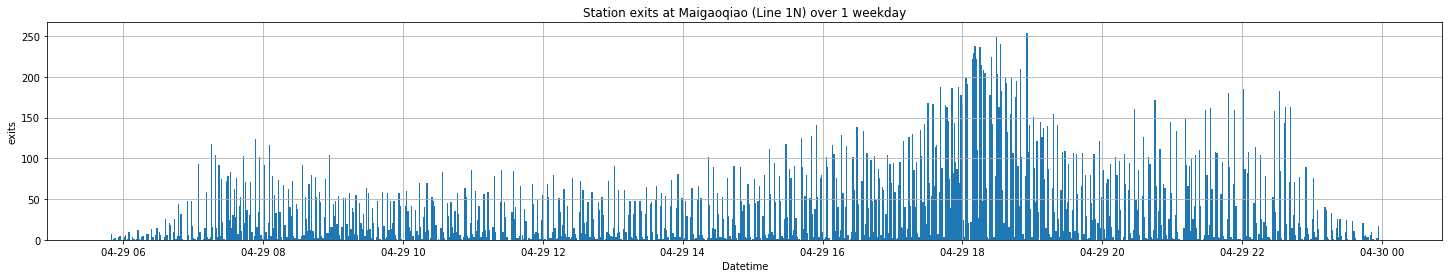

In [6]:
plot_day('1N', 1, 16, 'Maigaoqiao')

Note the strong clustering in the data corresponding to trains arriving. There's little reason for people to loiter in station after they've gotten off at their final stop. The headway on the northern portion of Line 1 is very short, 3 minutes, which this plot corroborates well.

Let's take a look at station entrances as well.

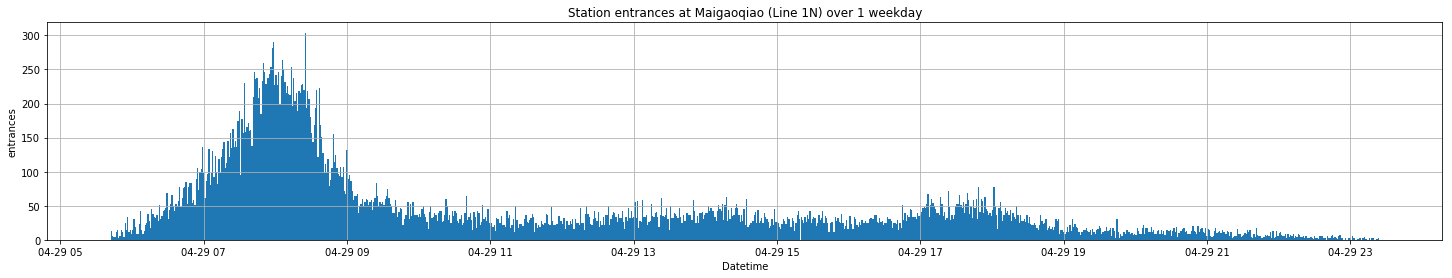

In [7]:
plot_day('1N', 1, 16, 'Maigaoqiao', Entry_Or_Exit=1)

It's unclear whether or not entrances exhibit the same periodicity. This will require further analysis.

## A little more data cleanup

Now that we've finished looking at station exits, we'll drop those from our dataframes since our interest is in arrival patterns.

In [8]:
for date in (weekdays + weekends):
    df[date] = df[date].loc[df[date]['Entry_Or_Exit'] == 1,:]
df[weekdays[0]].head()

,Time,Entry_Or_Exit,Line_Id,StationId
113726,2015-04-29 05:42:04,1,1,16
780703,2015-04-29 05:42:05,1,1,16
1602094,2015-04-29 05:42:11,1,1,16
113727,2015-04-29 05:42:12,1,1,16
1602095,2015-04-29 05:42:14,1,1,16


# Simple Arrival Distribution Analysis

On weekdays, the north portion of Line 1 has a fixed headway of 3 minutes (that is to say, at each station every 3 minutes another train arrives). Line 1 has a fixed, predictable headway of 3 minutes all day on weekdays, so the question we want to consider is if travelers adjust their arrival times are the station to account for these departures.

We'll begin with the following processing steps:
1. Pull out just the `Timestamp`s of entries at the Line 1 north terminus
2. Convert raw `Timestamp` to `Timedelta` hours after midnight on the day the data is from
3. Adjust `Timedelta` to time elapsed since the first train of the day
4. Convert `Timedelta` to seconds for easier calculations.
5. Use the module operator to bring all time

In [9]:
hw1 = 3*60 # seconds

df1 = {}

for date in weekdays:
#     df1[date] = df[date].loc[df[date]['Line_Id'] == 1]['Time']
    df1[date] = df[date].loc[df[date]['Line_Id'] == 1]
    df1[date] = df1[date].loc[df1[date]['Entry_Or_Exit'] == 1]
    df1[date] = df1[date].loc[:,['Time']]
    
    # timestamp - midnight of day - time of first train of day
    df1[date]['Time'] = (df1[date]['Time'] - pd.Timestamp(date) - pd.Timedelta(first[terminals[1][0]])).dt.seconds
    
    # account for periodicity
    df1[date]['adj_time'] = df1[date]['Time'] % hw1
    df1[date]['arr_period'] = df1[date]['Time'] // hw1    
    
df1[weekdays[0]].head()

,Time,adj_time,arr_period
113726,4,4,0
780703,5,5,0
1602094,11,11,0
113727,12,12,0
1602095,14,14,0


We'll approach this analysis on two fronts: trying the distribution without normalizing per 3-minute interval, and then doing so and comparing the differences.

## Distribution fitting without normalization

This method should be more accurate to the way we observe passengers arriving, but rush hour passengers may drown out passengers arriving during off-peak times.

We take all the arrival times since the first train and use the modulo operator to bring everything into a repeating 3-minute period

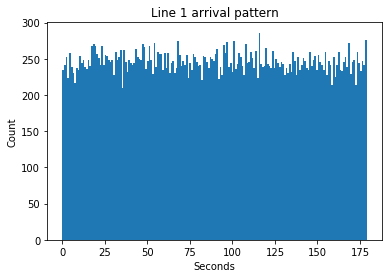

In [10]:
ap1 = np.array([])
for date in weekdays:
    ap1 = np.append(ap1, df1[date]['adj_time'].values)

plt.hist(ap1,bins=hw1)
plt.xlabel('Seconds')
plt.ylabel('Count')
plt.title('Line 1 arrival pattern')
plt.savefig('figs/l1arrivalpattern.png')
plt.show()

Looks uniform, but let's see what distribution fits this best.

/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/fitter/fitter.py:305: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return self.df_errors.ix[names]


,sumsquare_error
uniform,0.000016
gennorm,0.000016
kappa4,0.000016
powerlaw,0.000027
johnsonsb,0.000059


/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


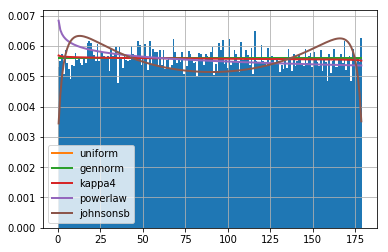

In [11]:
f1 = Fitter(ap1,bins=hw1,verbose=False)
warnings.simplefilter('ignore')
f1.fit()
warnings.simplefilter('default')
f1.summary()

Yep, it's uniform.

## Distribution fitting by period with normalization

Now instead of fitting a distribution by each arrival, we'll normalize 

1. group arrivals by period
2. loop through periods, skipping periods with too few arrivals
    a. bin arrivals during the period into intervals of 1 second (the resolution of our dataset)
    b. divide the resulting counts by the total number of arrivals in the period
    c. fold the resulting distribution into into a running dataset 
3. fit on the resulting array

/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:

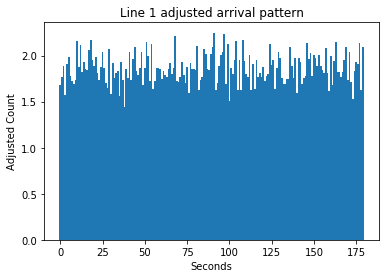

In [12]:
ad1 = np.zeros(hw1)
for date in weekdays:
    for name, group in df1[date].groupby('arr_period'):
        if group.shape[0] > 10:
            holder = np.zeros(hw1)
            for minute in group['adj_time']:
                holder[minute] += 1
            holder = holder/np.sum(holder)
            ad1 = ad1 + holder

plt.bar(np.arange(hw1),ad1,width=1)
plt.xlabel('Seconds')
plt.ylabel('Adjusted Count')
plt.title('Line 1 adjusted arrival pattern')
plt.savefig('figs/l1adjarrivalpattern.png')
plt.show()

/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:43: RuntimeWarning: floating point number truncated to an integer
  return 1.0 - sc.smirnov(n, x)
/home/Carlin/anaconda3/lib/python3.6/site-packages/fitter/fitter.py:305: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return self.df_errors.ix[names]


,sumsquare_error
uniform,0.000042
gennorm,0.000042
vonmises_line,0.000042
kappa4,0.000042
powerlaw,0.000042


/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5408: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)
/home/Carlin/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1615: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


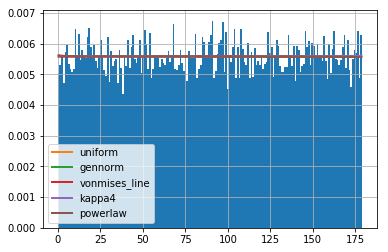

In [13]:
ad1 = np.repeat(np.arange(hw1),(np.rint(ad1*100)).astype(int))
f2 = Fitter(ad1,bins=hw1,verbose=False)
warnings.simplefilter('ignore')
f2.fit()
warnings.simplefilter('default')
f2.summary()